In [1]:
# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# numpy to calculate RMS with np.std()
import numpy as np

# pandas used for handling the large amounts of data in dataframes rather than python lists
import pandas as pd

# scipy for curve fitting
from scipy.optimize import curve_fit

# # Import datetime to get current date and time to title directory
# from datetime import datetime

# # Import os to create directories and store plots in them
# import os

# # Create a directory with the name: hit_reconstruction_MM-DD-YYYY_HHMMSS
# current_dateTime = datetime.now()
# date_string = str('%02d' %current_dateTime.month) + '-' + str('%02d' %current_dateTime.day) + '-' \
#     + str('%04d' %current_dateTime.year) + '_' + str('%02d' %current_dateTime.hour) + str('%02d' %current_dateTime.minute) \
#     + str('%02d' %current_dateTime.second)

# # Name the 'main' directory. This will hold the sub-directories that contain actual plots/data
# main_directory = '../Analysis_Results/Analysis_' + date_string 

# # Name the subdirectories:
#     # reconstruct directory will hold the reconstruction plots
#     # plot directory will hold intermediate plots (created from process) and the fit parameters
#     # intermidiate directory will store TOA vs RMS plots to help diagnose outliers
# reconstruct_directory = main_directory + '/hit_reconstruction'
# iterative_directory = main_directory + '/iterative_results'
# TOAvRMS_directory = main_directory + '/TOA_v_RMS'

# # Create the main_directory and the 3 sub-directories for reconstruction, TOAvRMS, and process
# os.mkdir(main_directory)
# os.mkdir(iterative_directory)
# os.mkdir(reconstruct_directory)
# os.mkdir(TOAvRMS_directory)

In [2]:
# Function parameters that are repeated throughout this program are given a '_f' as a suffix. This is to avoid incorrectly 
# overwriting variables.

def theoryFunction(t_f):
    '''
    Returns the theoretical RMS for electron cloud drifting in LAr based on given arrival time(s). 

    Parameters
    ----------
        t_f : array of float or float
            Array of Mean_TOA(s) for each pixel.

    Returns
    -------
        array of float or float: 
            Array of expected RMS' corresponding to the TOA in parameter: t.
    '''
    
    D = 682.23 # mm^2/s
    v = 1.648 * 10**6 # mm/s
    RMS = ((2*(t_f)*D/v**2)**(1/2))
    return RMS

def sqrtFunc(x_f, a_f):
    '''
    Returns the value a*sqrt(x) for given x(s). 

    Parameters
    ----------
        x_f : array of float or float
            Array of independent float values.
        a_f : float
            Scaling factor of the sqrt function.

    Returns
    -------
        array of float or float: 
            Value(s) equal to a*sqrt(x) corresponding to the array parameter x.
    '''
    return a_f*(x_f)**(1/2)

def fitLine(function, x_f, y_f):
    '''
    Returns fitting parameters, dependent on type of fitted line, for a given dataset. 

    Parameters
    ----------
        function : Function
            General mathematical function returning the dependent y-value for a given independent x-value.
        x_f : array of float
            Independent variables corresponding to the y-array.
        y_f : array of float
            Dependent variables corresponding to the x-array.

    Returns
    -------
        array of float: 
            Array of fitting parameters for each needed parameter in function.
    '''
    params, _ = curve_fit(function, x_f, y_f)
    return params

def gaussFunc(x_f, A_f, x0_f, sigma_f):
    '''
    Returns the dependent value on a Gaussian curve for given x(s). 

    Parameters
    ----------
        x_f : array of float or float
            Array of independent float values.
        A_f : float
            Amplitude of the Gaussian curve.
        x0_f : float
            Mean value for the Gaussian distribution.
        sigma_f : float
            Standard Deviation for the Gaussian distribution.

    Returns
    -------
        array of float or float: 
            Dependent value on a Gaussian curve corresponding to the array parameter x.
    '''
    return A_f * np.exp(-(x_f - x0_f) ** 2 / (2 * sigma_f ** 2))

def gaussFitHist(data_f, binNum_f):
    '''
    Takes in a histogram and returns the gaussian fitting parameters for the histogram as well as the points used for fitting. 

    Parameters
    ----------
        data_f : array of float
            Array of values used in histogram distribution.
        binNum_f : int
            Number of bins used in histogram plot.

    Returns
    -------
        gauss_params : array of float or float 
            Fitting parameters used to generate a Gaussian curve fitted to histogram bars.
        gaussDataPoints : DataFrame
            DataFrame filled with xvalues and yvalues of the points in the center and on top of each histogram bar.
    '''
    counts, bins = np.histogram(data_f, bins = binNum_f)
    binCenters = []
    
    for i in range(len(bins) - 1):
        binCenters.append((bins[i]+bins[i+1])/2)

    gaussDataPoints = pd.DataFrame(data={'xvalues': binCenters, 'yvalues': counts
                                        })
                                                   
    gauss_params, _ = curve_fit(gaussFunc, gaussDataPoints["xvalues"], gaussDataPoints["yvalues"],
                                p0 = [gaussDataPoints["yvalues"].max(), data_f.mean(), data_f.std()])
    
    return gauss_params, gaussDataPoints

def getBinNum(binNum_f, maxVal0_f, minVal0_f, maxVal_new_f, minVal_new_f):
    '''
    Returns a bin number, proportional to the original bin number, for a subset of data. 

    Parameters
    ----------
        binNum_f : int
            Original number of bins used in histogram plot.
        maxVal0_f : float
            Max value on the histogram when binning using binNum.
        minVal0_f : float
            Min value on the histogram when binning using binNum.
        maxVal_new_f : float
            Max value on the histogram for the subset of data.
        minVal_new_f : float
            Min value on the histogram for the subset of data.

    Returns
    -------
        newBinNum : int
            Bin number used for the subset of data that will maintain the midth of the original bins.
    '''
    newBinNum = abs(int(binNum_f * (maxVal_new_f - minVal_new_f)/(maxVal0_f - minVal0_f)))
    if newBinNum == 0:
        return 1
    else:
        return newBinNum

def getT0_SingleEvent(dataframe_f, event_num_f, fit_param_f):
    '''
    Returns the final time shift for a given event. 

    This function iterates through a process: 
    Find the pixel with the min_delta_StDev for a given event -> Find delta_t to move the pixel's given StDev onto 
    the expected curve -> Store this delta_t -> Shift all mean_TOA by that delta_t -> Find the pixel with the min_delta_StDev 
    for a given event
    This process continues until the delta_t = 0 (the min_delta_StDev = 0) and the previously stored delta_t is returned.

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 'RMS', 'expected_RMS', 'delta_StDev'.
        event_num_f : int
            Event number for the event we are finding t0 for.
        fit_param_f : array of float
            Array of fitting parameters describing the expected_RMS for a given mean_TOA.

    Returns
    -------
        delta_t_return : float
            The last time shift before delta_t = 0. This is the t0 for the given event.
    '''
    # Create a copy of the dataframe containing only points for a given event 
    event_dataframe = dataframe_f[(dataframe_f["event"] == event_num_f)].copy().reset_index(drop = True)
    
    # Establish a very large delta_t. This will get overwritten, if a large t0 is returned, the function didn't work properly.
    delta_t = float('inf')
    
    while True:
        delta_t_return = delta_t
        
        # Find the delta_StDev for each pixel with their new times
        event_dataframe["expected_RMS"] = sqrtFunc(event_dataframe["mean_TOA"], fit_param_f)
        event_dataframe["delta_StDev"] = event_dataframe["RMS"] - event_dataframe["expected_RMS"]

        # Find the min delta_StDev
        smallest_stdev_index = event_dataframe["delta_StDev"].idxmin()
        smallest_stdev = event_dataframe.iloc[[smallest_stdev_index]]["RMS"][smallest_stdev_index]

        # Assume this StDev fits on our functional form. 
        # Find the expected TOA:
        expected_TOA = (smallest_stdev/fit_param_f)**2
        # Find the delta_T to shift the actual_TOA to expected_TOA
        delta_t = expected_TOA - event_dataframe.iloc[[smallest_stdev_index]]["mean_TOA"][smallest_stdev_index]

        # At this point, if we get delta_t = 0, we have finished the TOA shifting
        if delta_t == 0:
            return delta_t_return
        
        # Shift all pixel's TOA by the delta_t
        event_dataframe["mean_TOA"] = event_dataframe["mean_TOA"] + delta_t
        
def getZValues(dataFrame_f):
    '''
    Returns the Z-position for pixels in an event with a calculated t0. 

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 't0'.

    Returns
    -------
        dataFrame_f["Z_Position"] : array
            Array containing the expected Z-position based on the electron drift velocity and a calculated t0 for the event.
    '''
    v0 = 1.648 * 10**6 # mm/s
    
    dataFrame_f["Z_Position"] = (dataFrame_f["mean_TOA"] - dataFrame_f["t0"])*v0
    return dataFrame_f["Z_Position"]

def bestFitRemoveOutliers(dataframe_f, minStDev_indices, contribution_lim, cutoff= 3):
    
    # dataframe_f is the full dataframe. We want to work with the minStDev for each event.
    # Start by defining a smaller dataframe consisting of the smallest StDev for each event
    df = dataframe_f.loc[minStDev_indices]
    # Initialize array to hold fit history
    fit_history = []
    # Initialize loop breaker, avoiding infinite loop
    counter = 0
    # Fit the smallest StDev pixels with a sqrt curve
    # Store the returned fitting parameter in best_fit
    fit_history.append(fitLine(sqrtFunc, df["mean_TOA"], df["RMS"])[0])
    best_fit = fit_history[-1]
    
    # Loop is to run until we get the same fit repeated.
    # Boolean flag initially set to False as it will later take boolean value whether the new fit and previous fit
    # are the same.
    flag = False   
    while not flag:
        
        # Counter += 1 for every iteration
        counter += 1
        # Store new fit in old fit variable
        best_fit = fit_history[-1]
        
        # Calculate the expected_RMS and delta_StDev for values in list
        df["Expected_RMS"] = sqrtFunc(df["mean_TOA"], best_fit)
        df["delta_StDev"] = df["RMS"] - df["Expected_RMS"]
    
        df["Event_Outlier"] = defineOutliers(df, contribution_lim)
        
        # Get new fit excluding outliers
        fit_history.append(fitLine(sqrtFunc, df[df["Event_Outlier"] == False]["mean_TOA"], 
                                             df[df["Event_Outlier"] == False]["RMS"])[0])
        
        # Check whether the new fit is same as old
        flag = (best_fit == fit_history[-1])
    
        if counter == cutoff:
            flag = True
    
    print("Fit returned after %d iterations." %counter)
    return best_fit

def defineOutliers(dataframe, contribution_lim):
   
    # Create copy of dataframe
    df_copy = dataframe.copy()
    df_copy.loc[:, "Event_Outlier"] = False
    # Define boolean flag change
    change = True
    
    while change:
        # Find the delta_StDev RMS and mean
        mu = df_copy[df_copy["Event_Outlier"] == False]["delta_StDev"].mean()
        sigma = df_copy[df_copy["Event_Outlier"] == False]["delta_StDev"].std()
        
        df_copy["Chi2_Value"] =  (mu - df_copy["delta_StDev"])**2 / sigma**2
        
        maxChi_id = df_copy[df_copy["Event_Outlier"] == False]["Chi2_Value"].idxmax()

        if df_copy.loc[maxChi_id, "Event_Outlier"] == False and df_copy.loc[maxChi_id, "Chi2_Value"] >= contribution_lim:
            df_copy.loc[maxChi_id, "Event_Outlier"] = True
        else:
            change = False
    
    return df_copy["Event_Outlier"]

In [3]:
# Introduce Global Variables for event num and file paths/names

directory_path = '/scratch/group/mitchcomp/DUNE/data/Standard/muon_rtd_2023-07-01_152715'
resets_file_name = 'resets_output.txt'
g4_file_name = 'g4_output.txt'

# Define the minimum nResets per pixel to be considered
reset_num = 8

# Define number of standard deviations and chi squared away from mean to be considered an outlier
numSigma = 5
chiSquared_Lim = 9
binNum = 100
total_events = 100

In [4]:
# Open the resets_output.txt file and read into pandas dataframe
resets_df = pd.read_csv(directory_path + '/' + resets_file_name)

# Setting Up the DataFrame

In [5]:
# Filter out any pixels that have resets < 3 times (less than 3 occurences in the df)

# Define a new dataframe containing event, x_pixel, y_pixel and how many resets occured at each pixel
num_resets_df = resets_df.groupby(["event", "pixel_x", "pixel_y"], as_index=False).size()

# In the line above, we are defining the dataframe reset_num_df by grouping the rows by event, x_pixel, and y_pixel and
# using .size() to give us the size (number of occurences) of those groups stored in a "size" column. 

# Select only the occurences of pixels with the event == EVENT_NUM and num_resets (size) > reset_num
pixels_Resets = num_resets_df[(num_resets_df["size"] >= reset_num)]

# merge pixels_of_interest with the resets_df based on pixels
merged_df = pixels_Resets.merge(resets_df[["event", "pixel_x", "pixel_y", "reset_time"]], how = 'left', 
                                 on = ["event", "pixel_x", "pixel_y"])

In [6]:
# Find the mean TOA (mean reset_time) for each pixel

# This can be done with .groupby().mean() as it will group the rows of the df by ["event", "pixel_x", "pixel_y"]
# and include a 4th column that is the mean of reset_time for each grouping

# .groupby().mean() calculates the mean of the column that wasn't included in the grouping. In our case we didn't include 
# "reset_time" in the groupby statement, so the 4th column will be the mean of each group's reset_time

mean_TOA_df = merged_df[["event", "pixel_x", "pixel_y", "reset_time"]].groupby(["event", "pixel_x", "pixel_y"], 
                                                                               as_index=False).mean()

# Renames the 4th column from reset_time -> mean_TOA. groupby() keeps the original column names
mean_TOA_df = mean_TOA_df.rename(columns = {"reset_time" : "mean_TOA"})

In [7]:
# Similarly to the previous cell, we can find the RMS of each pixel's reset time by using .groupby().std()
RMS_df = merged_df[["event", "pixel_x", "pixel_y", "reset_time"]].groupby(["event", "pixel_x", "pixel_y"], as_index=False).std()

# Renames the 4th column from reset_time -> mean_TOA. groupby() keeps the original column names
RMS_df = RMS_df.rename(columns = {"reset_time" : "RMS"})

In [8]:
# Merge the mean_TOA_df and RMS_df to have completed datafram with event, pixels, TOA, and RMS
pixelTime_df = mean_TOA_df.merge(RMS_df, how = 'left', on = ["event", "pixel_x", "pixel_y"])

# Create copy df of the complete set: pixelTime_df

main_df = pixelTime_df.copy().reset_index(drop = True)

# Finding t0

In [9]:
# Find the indicies for the min RMS for each event
min_indices = []
for event_num in range(total_events):
    min_indices.append(main_df[(main_df["event"] == event_num)]["RMS"].idxmin())

In [10]:
# Get the best fit from the data by iterating and removing outliers
functionalForm = bestFitRemoveOutliers(main_df, min_indices, chiSquared_Lim)
print('Functional Form: %5E * sqrt(mean_TOA)' %functionalForm)

Fit returned after 2 iterations.
Functional Form: 1.965232E-05 * sqrt(mean_TOA)


In [11]:
# Create a dataframe t0_df, consisting of the event number and the t0 corresponding to that event
ts = []
events = range(total_events)
for n in events:
    ts.append(getT0_SingleEvent(main_df, n, functionalForm))
    
t0_df = pd.DataFrame(data ={"event": events, "t0": ts})

Gaussian Parameters: A: 7.25172E+00, x0: -2.95901E-05, sigma: 3.58221E-05


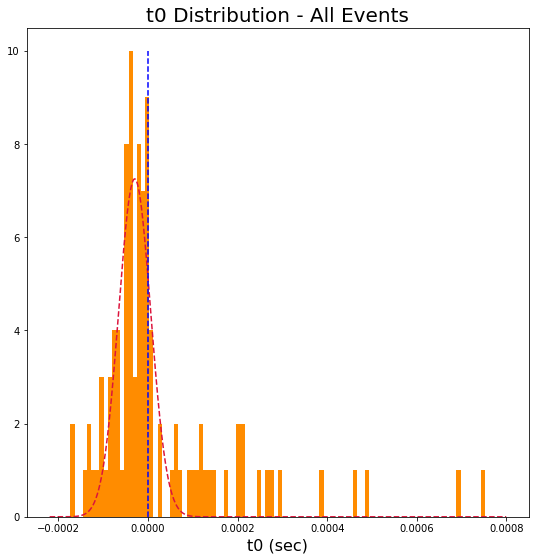

In [12]:
plt.figure(figsize = (9,9))
plt.hist(t0_df["t0"], bins = binNum, color = 'darkorange')

t0_gauss_params, hist_data = gaussFitHist(t0_df["t0"], binNum) 
# Plot the Gaussian Fit
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 1000)
ys = gaussFunc(xs, *t0_gauss_params)
plt.plot(xs, ys, '--', color = 'crimson', label = 'Gaussian Fit')
plt.title('t0 Distribution - All Events', fontsize = 20)
plt.xlabel('t0 (sec)', fontsize = 16)
print('Gaussian Parameters: A: %3.5E, x0: %3.5E, sigma: %3.5E' %(t0_gauss_params[0], t0_gauss_params[1], 
                                                                 t0_gauss_params[2]))
# Plot vertical line at t = 0
x = [0]*100
y = np.linspace(0, 10, 100)
plt.plot(x, y, '--', color = 'blue')
plt.show()
plt.close()

# Reconstruct and Compare to G4 data

In [13]:
# Open the g4_output.txt file and read into pandas dataframe

g4_df = pd.read_csv(directory_path + '/' + g4_file_name)

In [14]:
# Add the t0 dataframe as a 't0' column to the main_df by aligning the event numbers
reconstruction_df = main_df.copy().reset_index(drop = True)
reconstruction_df = reconstruction_df.merge(t0_df, how = 'left', on = ["event"])

# Convert the pixel numbers to a position in mm
reconstruction_df["X_Position"] = reconstruction_df["pixel_x"] * 4
reconstruction_df["Y_Position"] = reconstruction_df["pixel_y"] * 4
reconstruction_df["Z_Position"] = getZValues(reconstruction_df)

In [15]:
# To plot the G4 data quickly, import LineCollection. This avoiding iteratin grows and plotting it that way
from matplotlib.collections import LineCollection

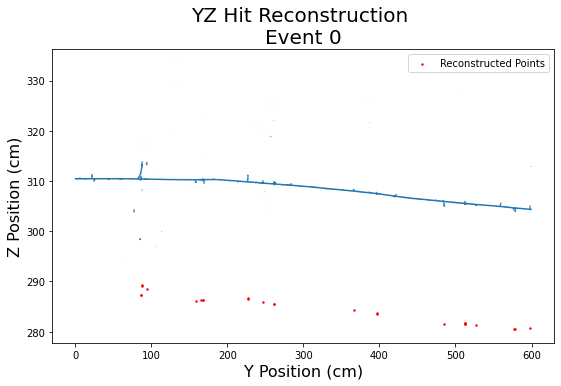

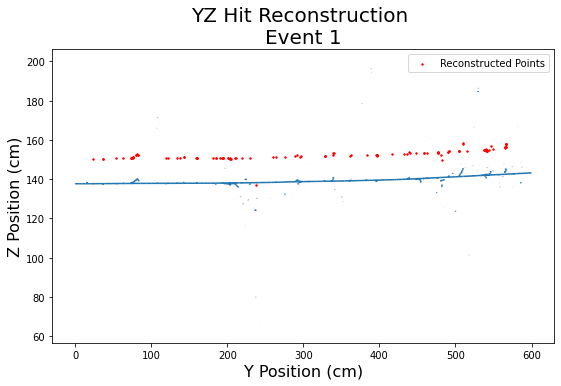

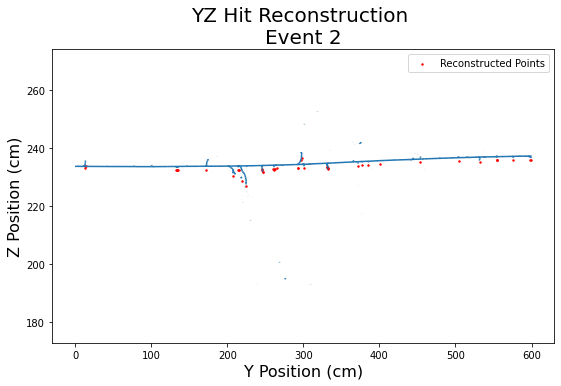

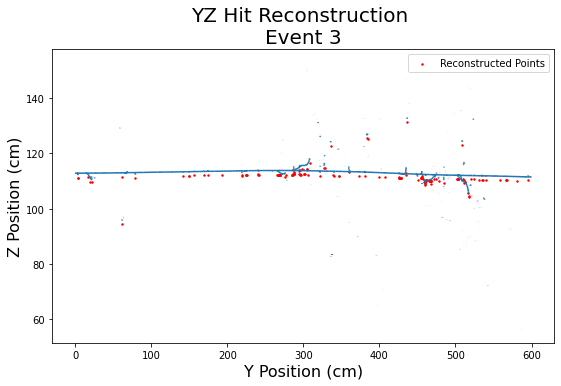

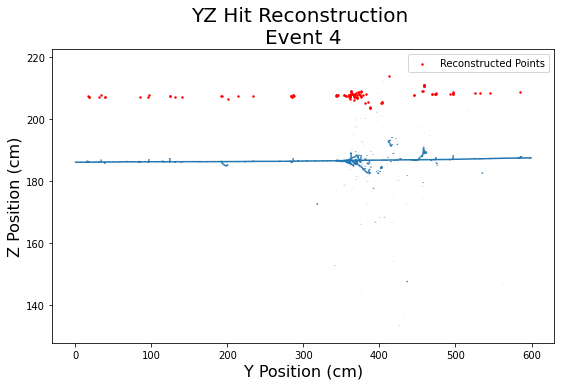

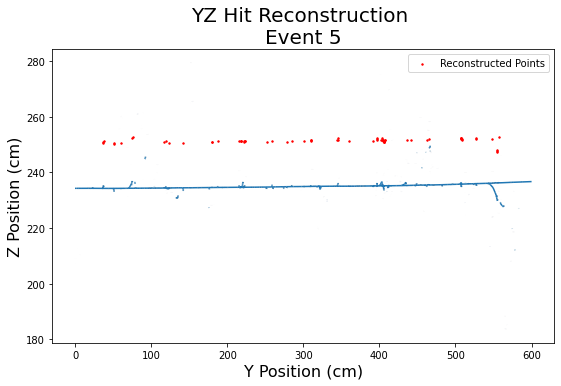

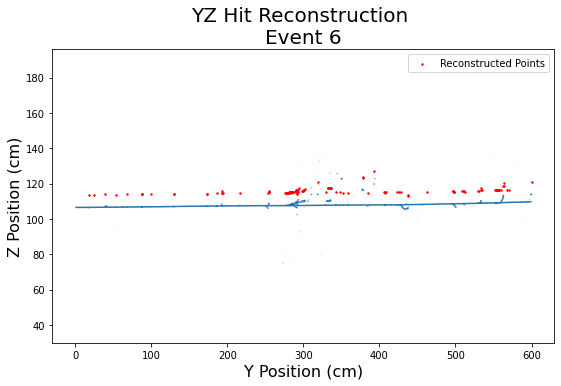

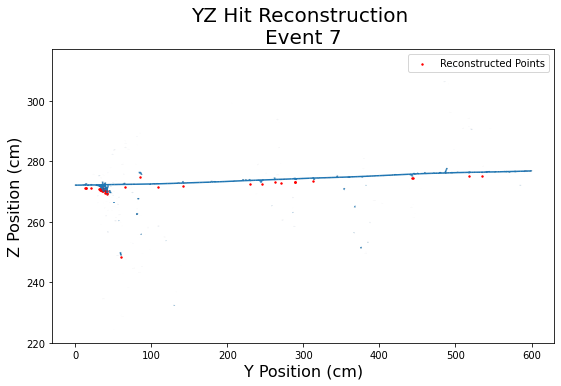

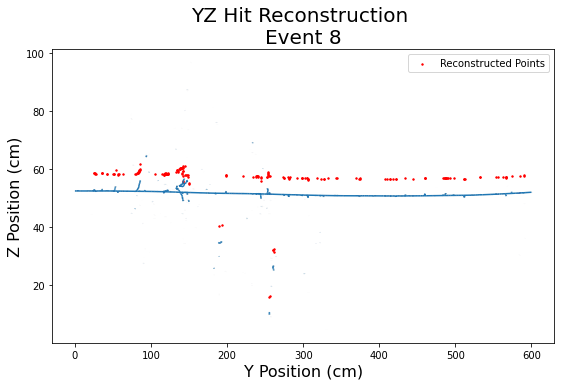

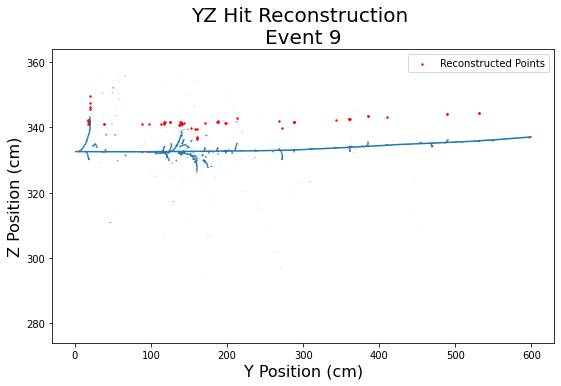

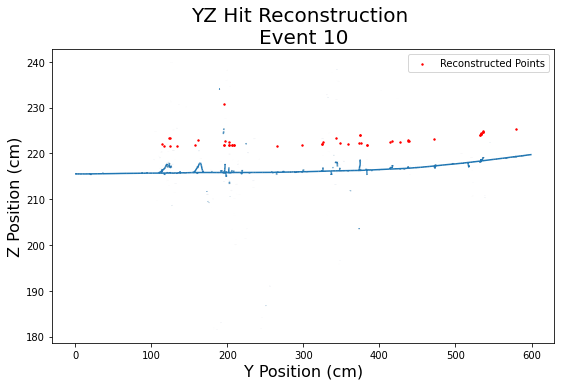

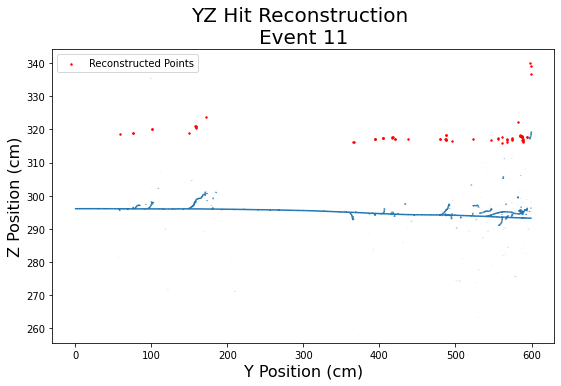

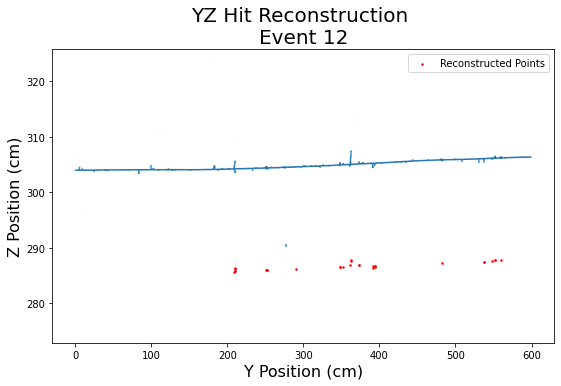

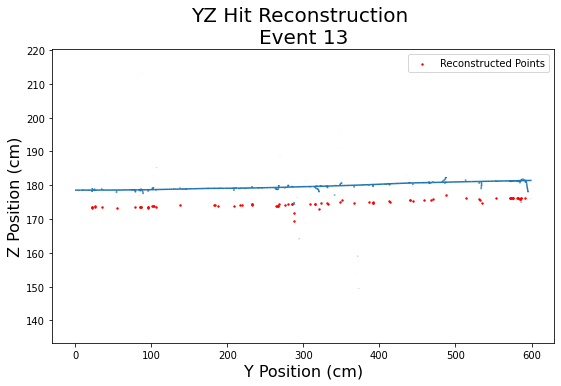

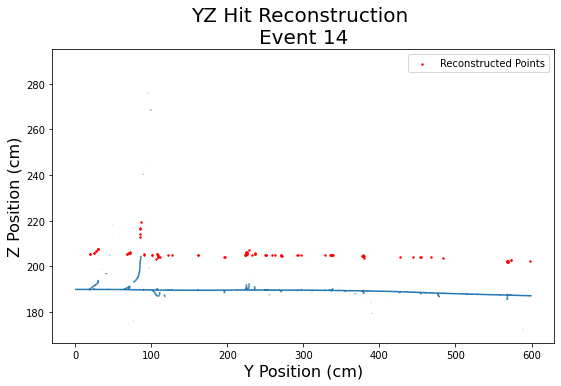

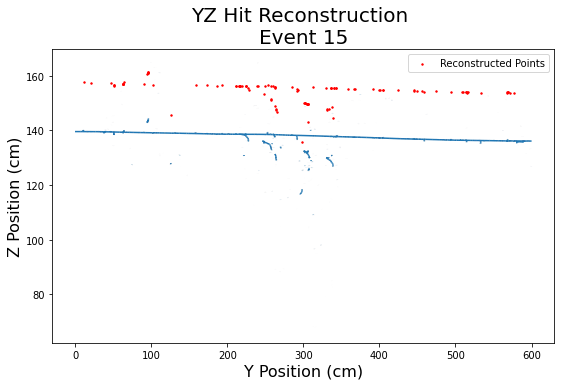

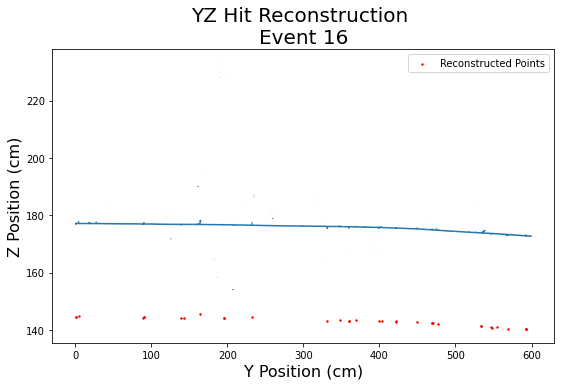

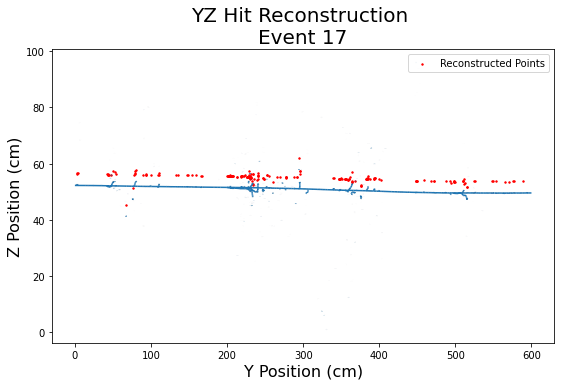

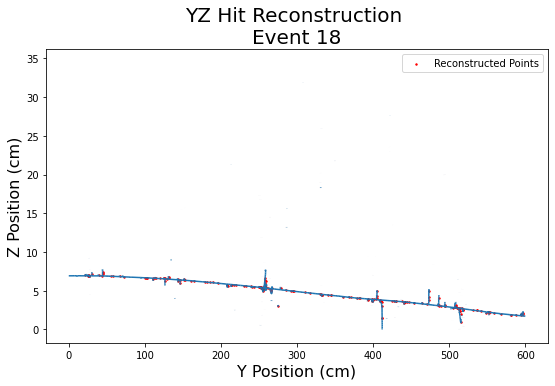

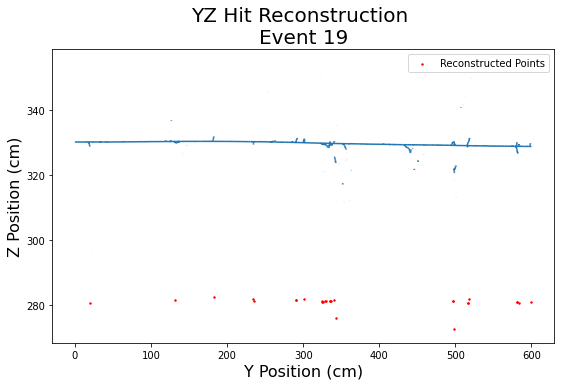

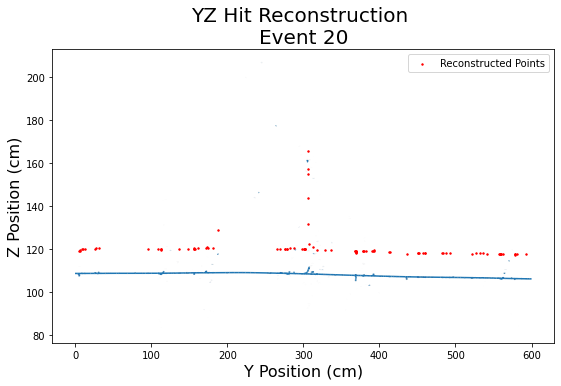

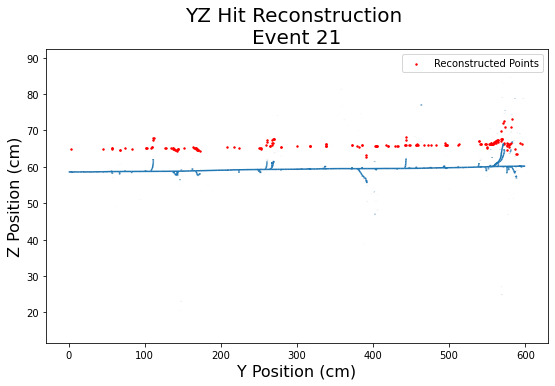

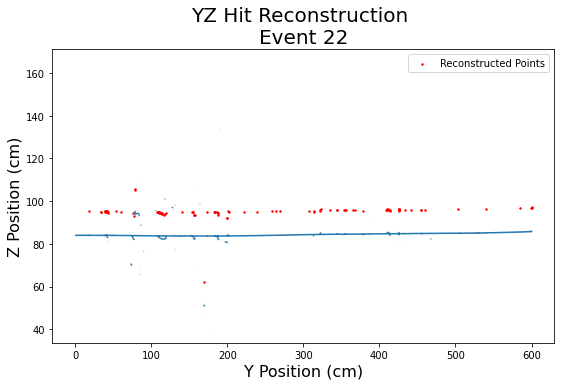

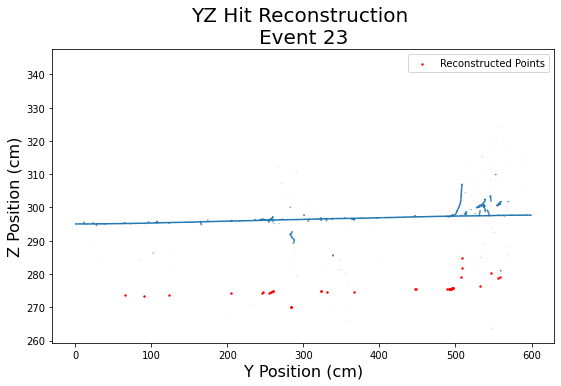

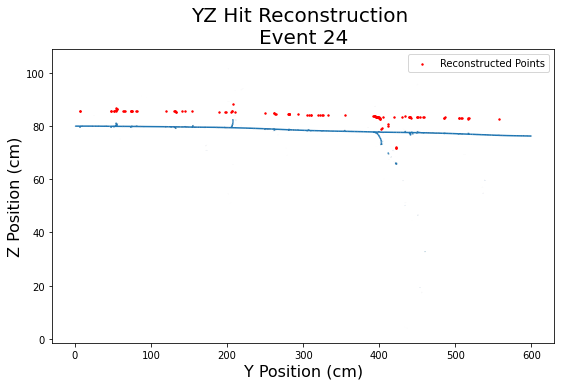

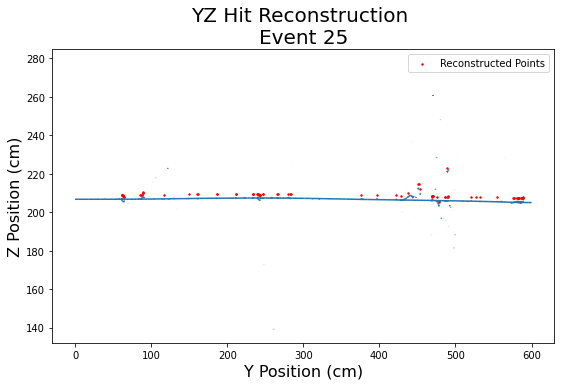

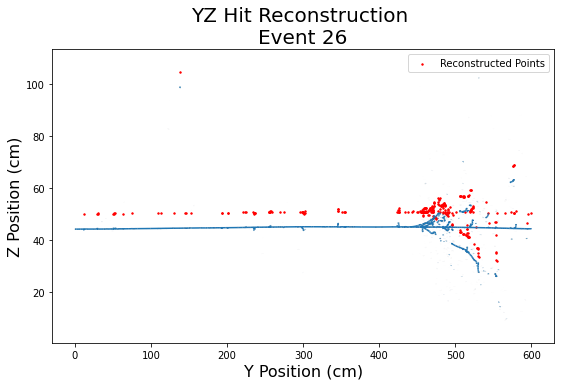

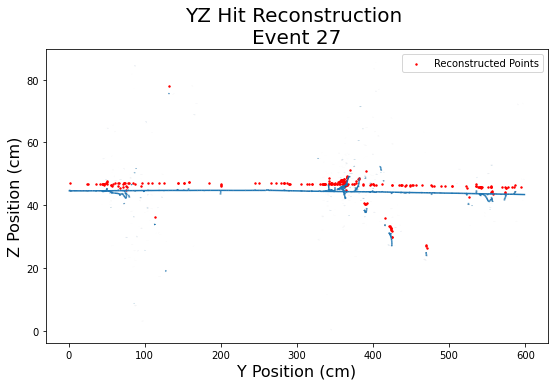

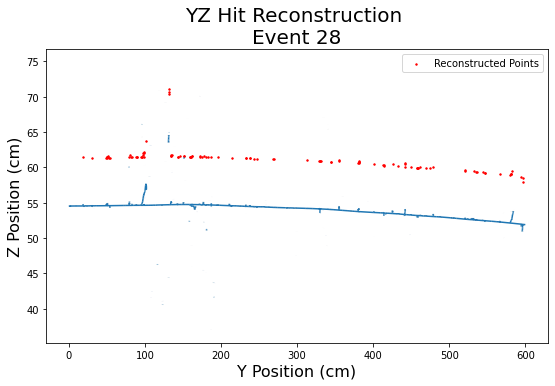

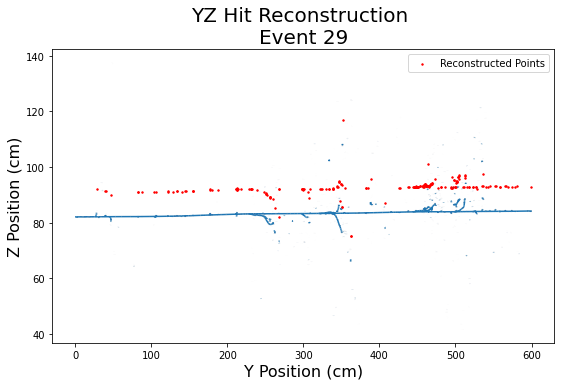

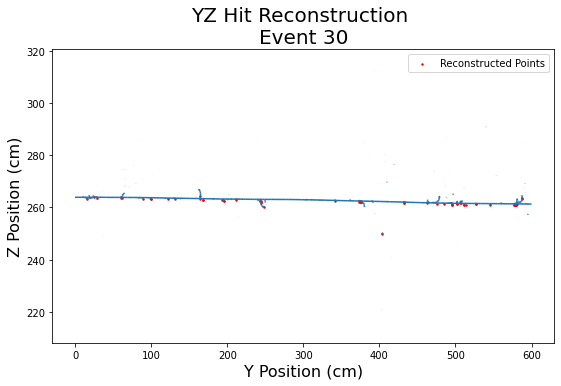

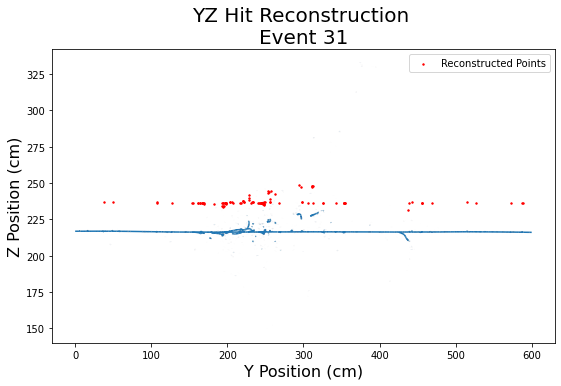

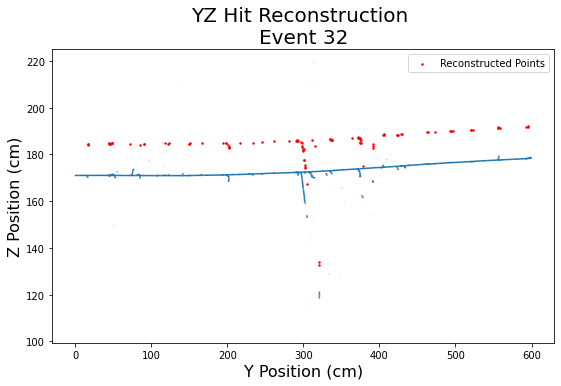

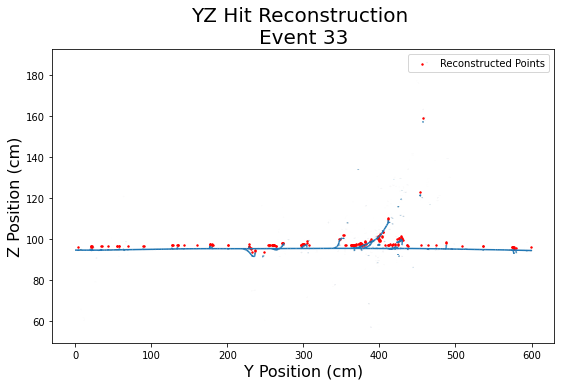

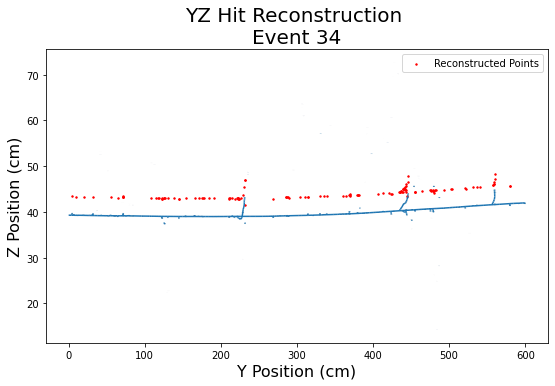

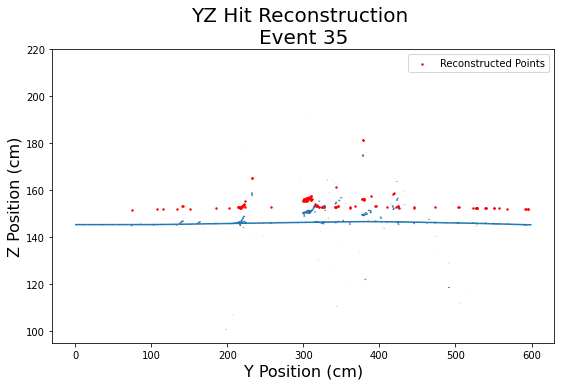

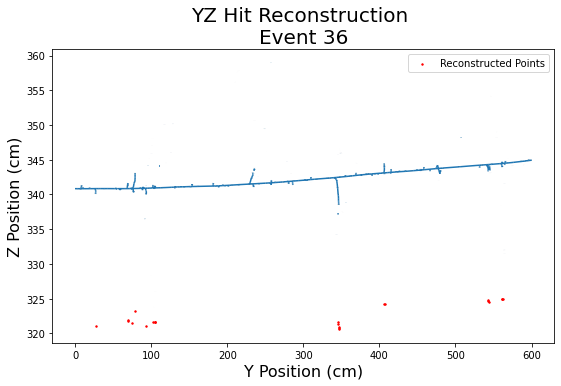

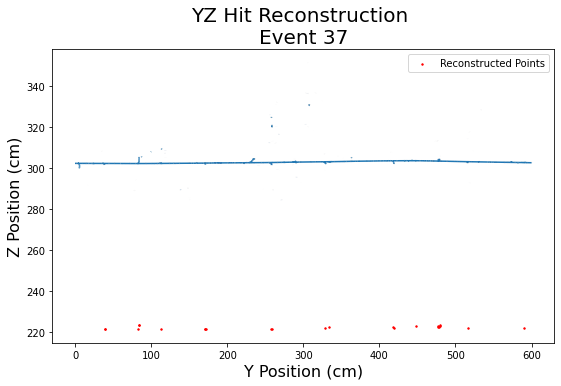

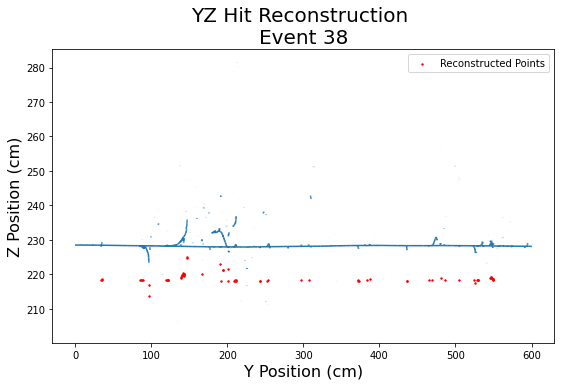

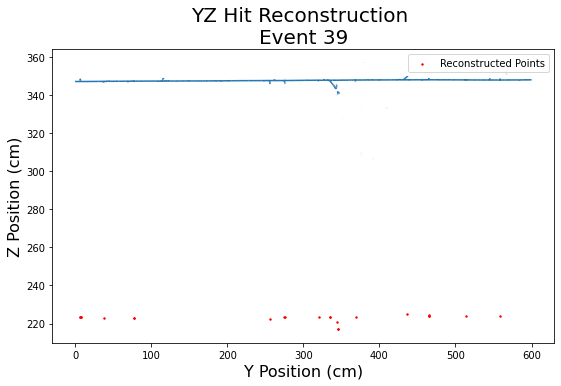

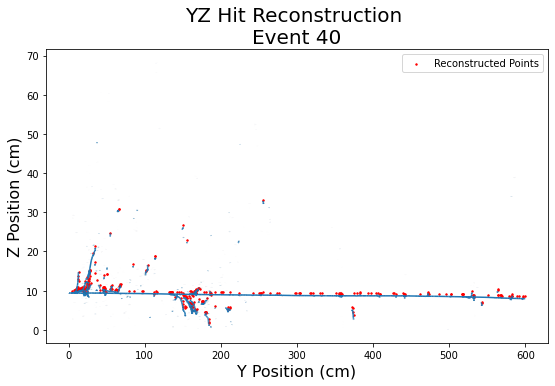

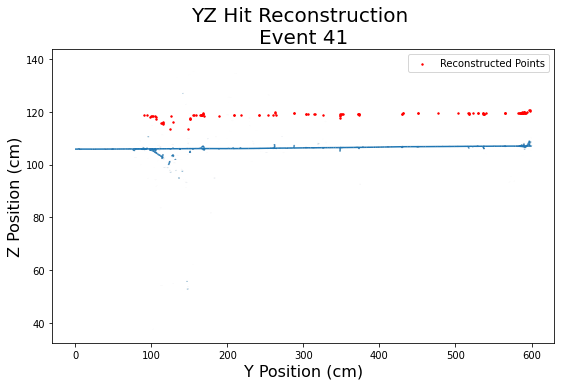

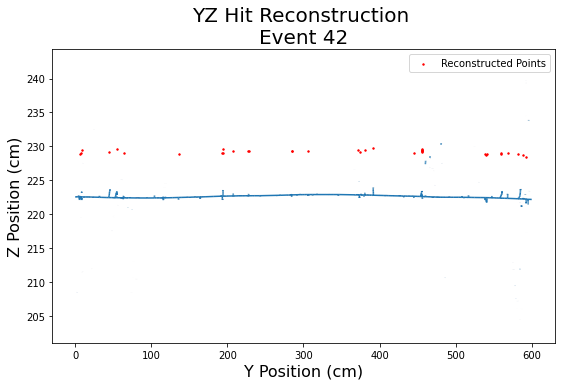

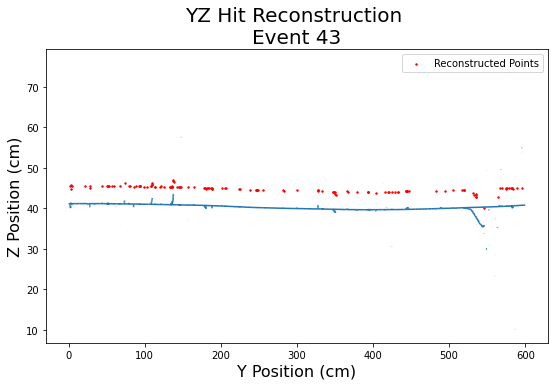

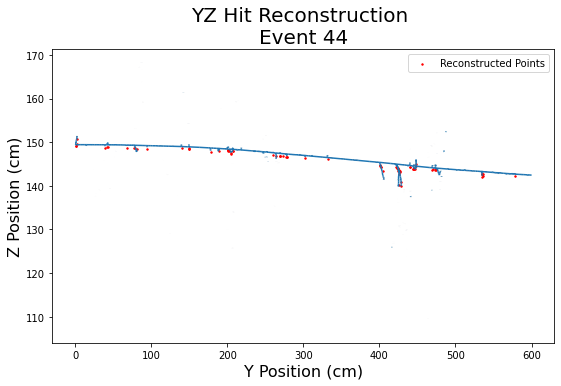

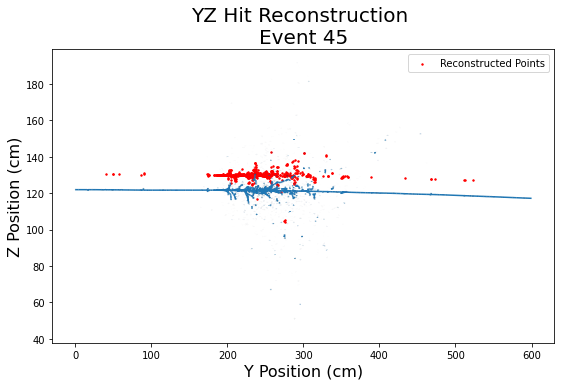

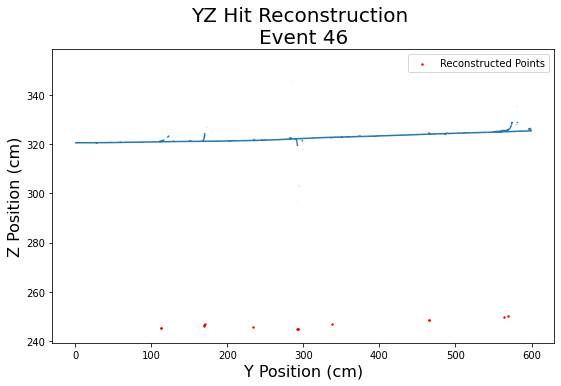

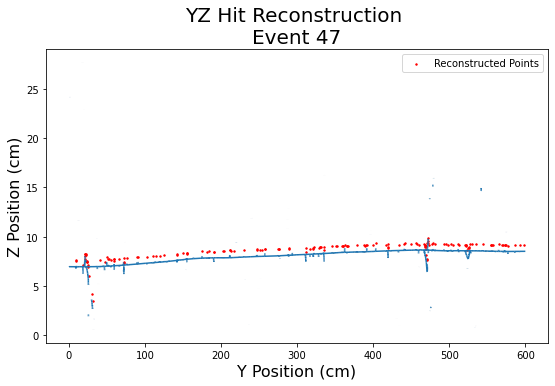

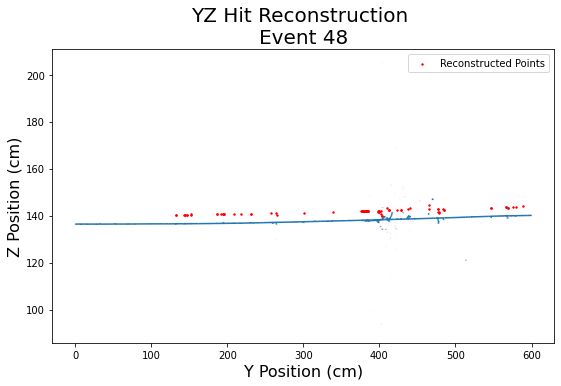

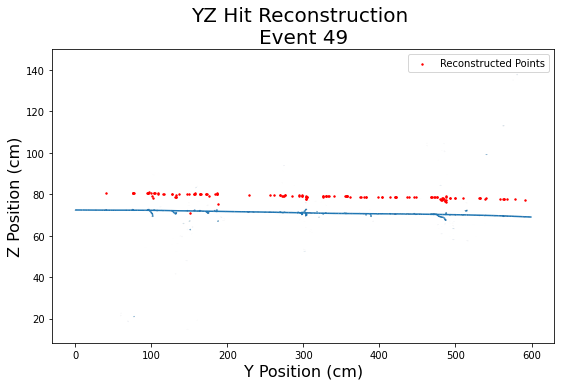

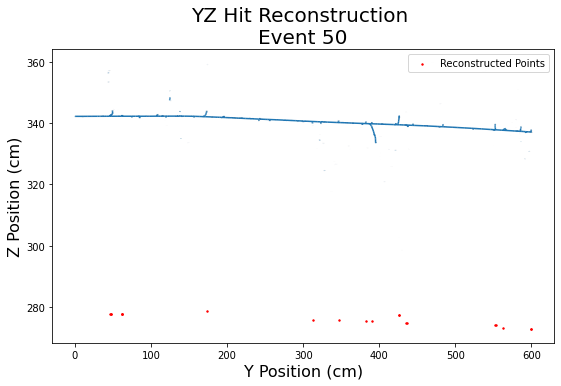

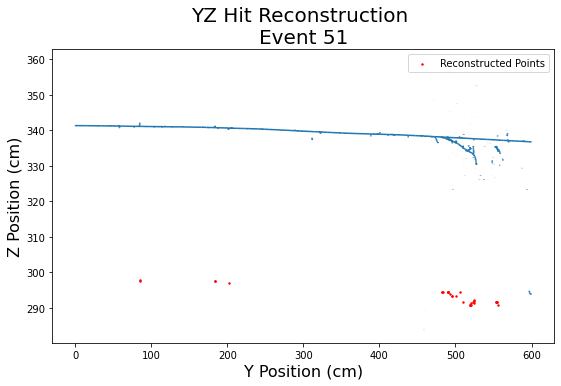

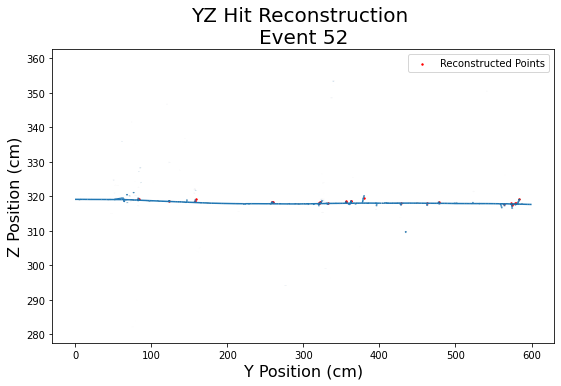

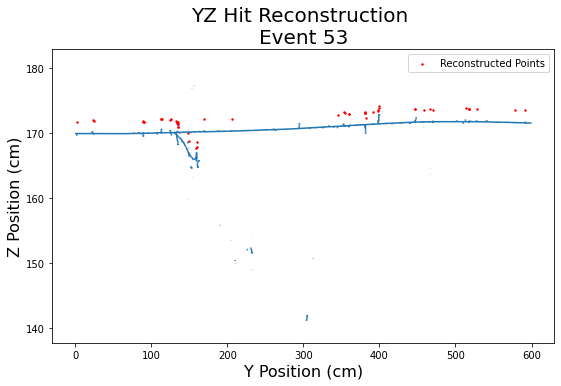

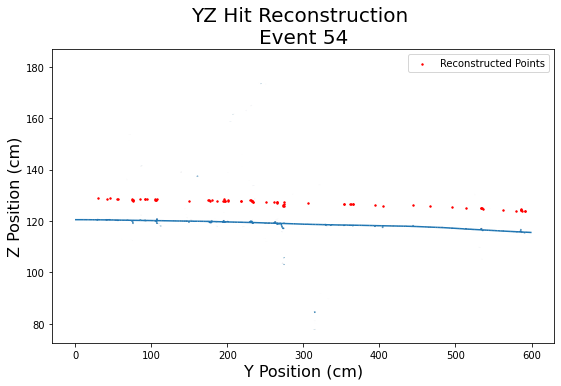

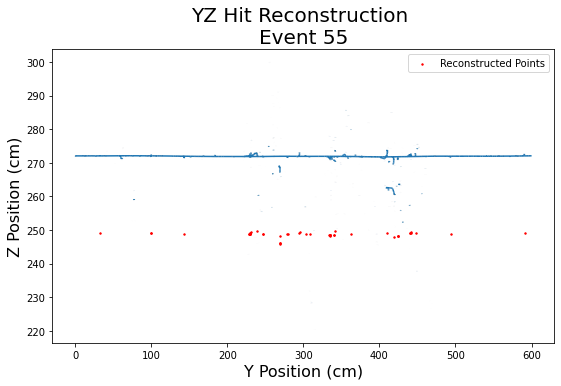

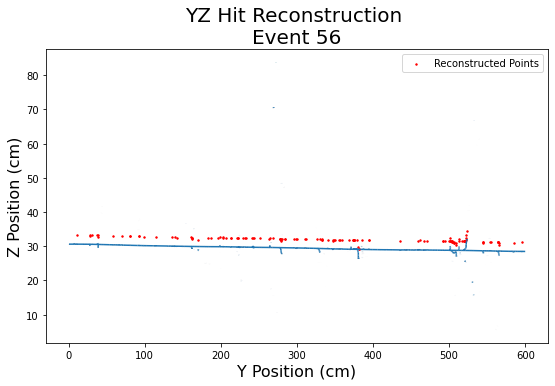

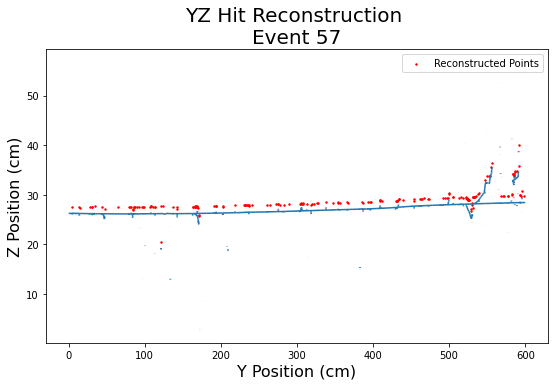

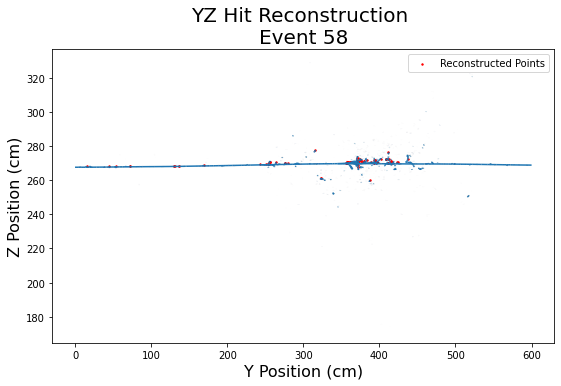

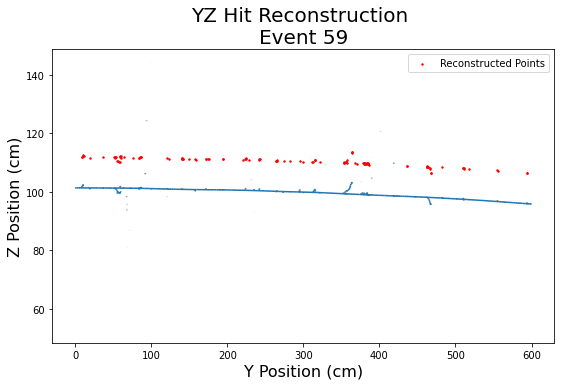

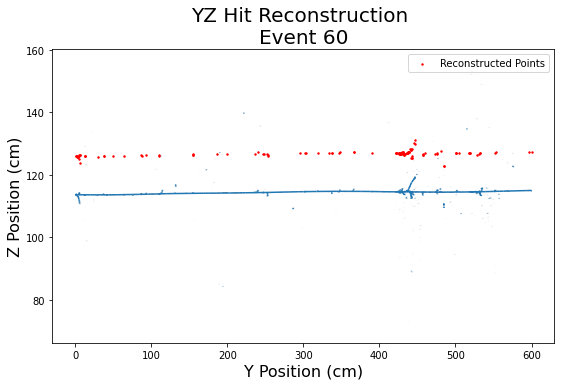

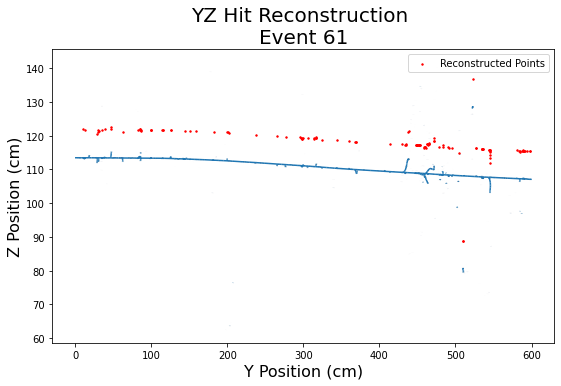

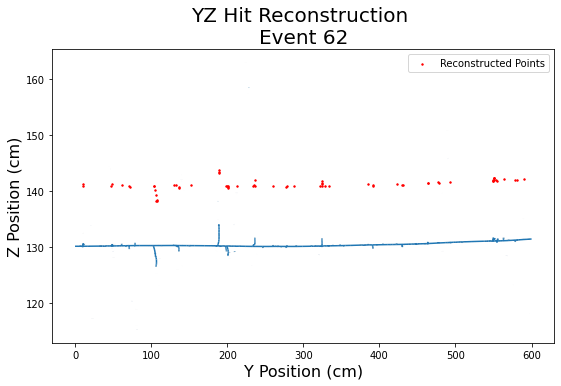

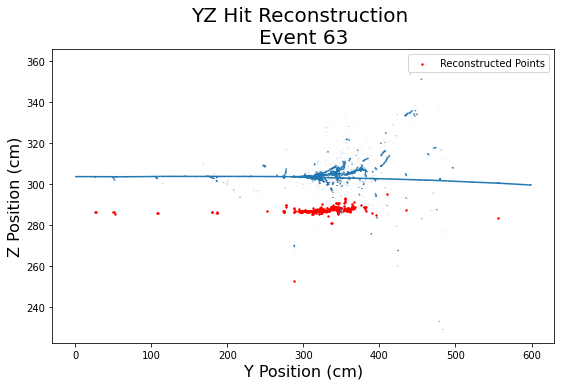

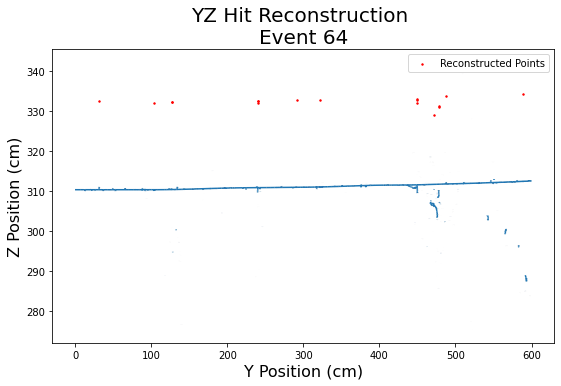

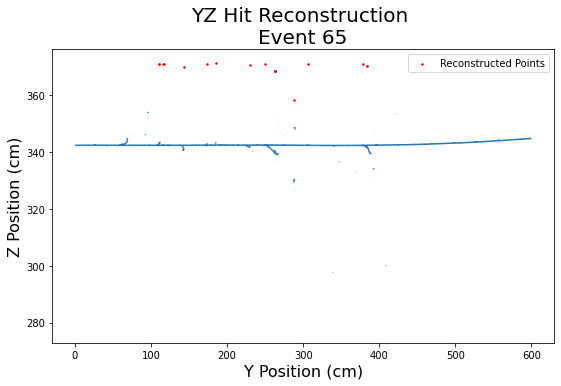

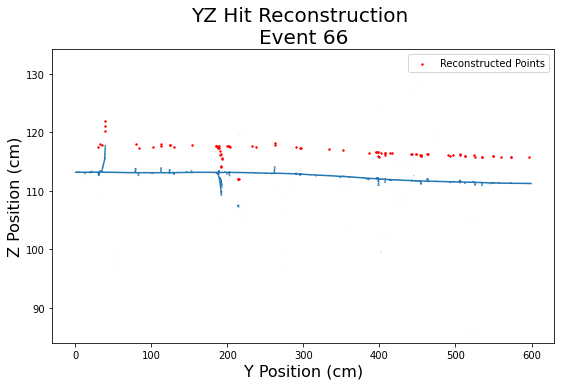

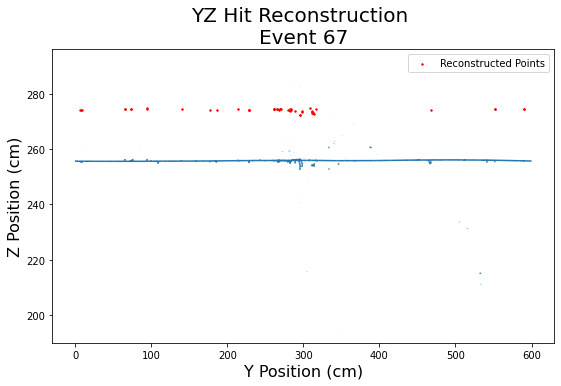

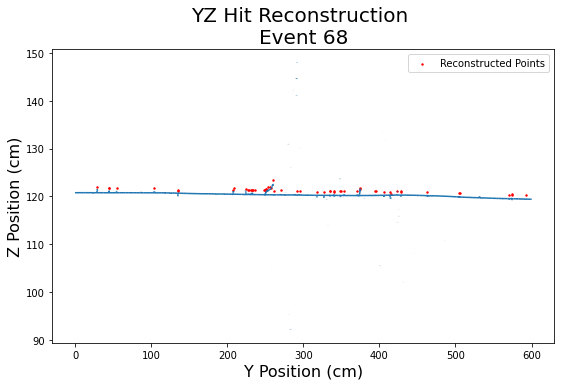

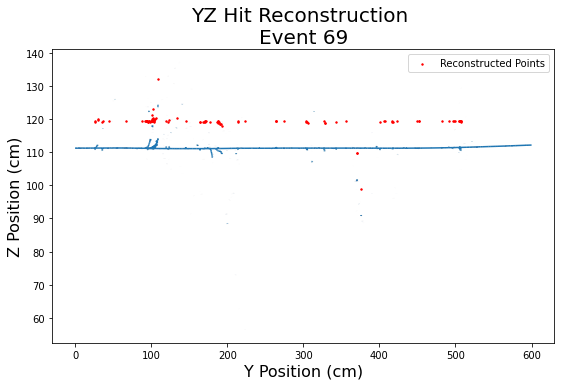

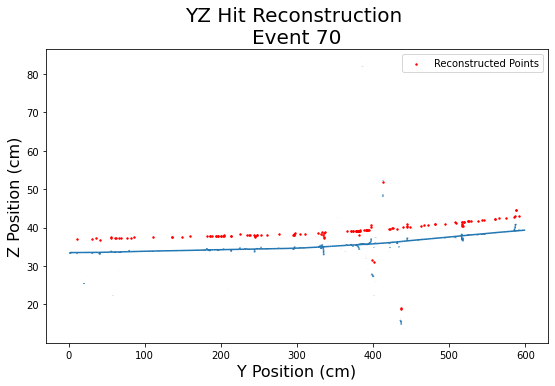

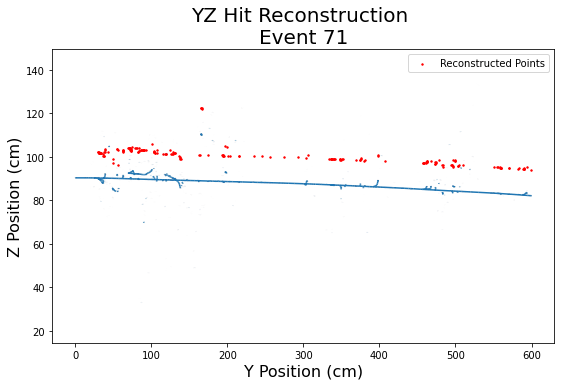

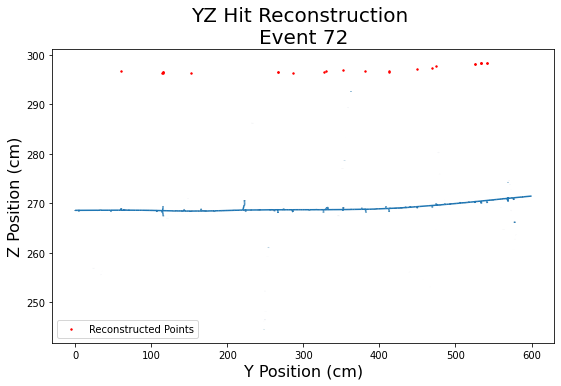

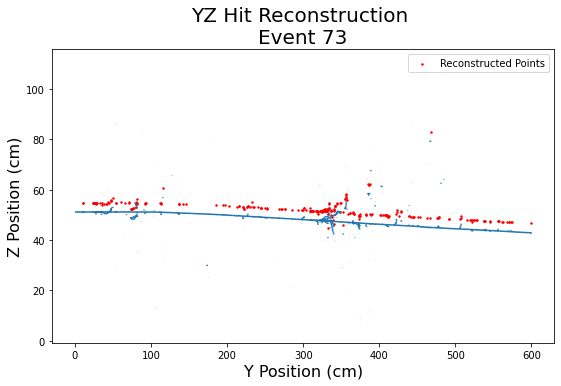

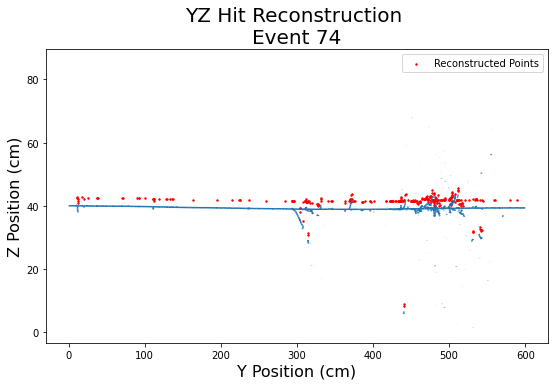

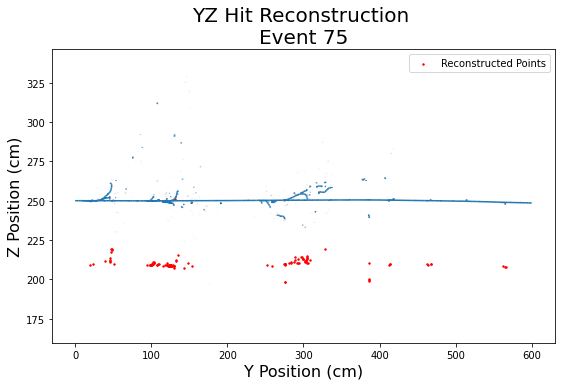

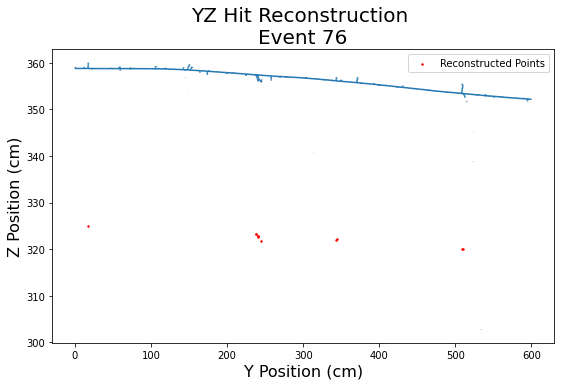

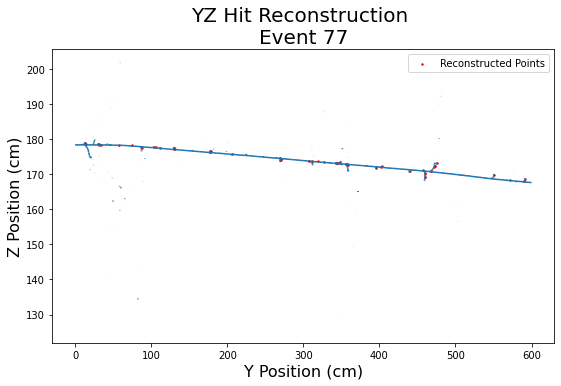

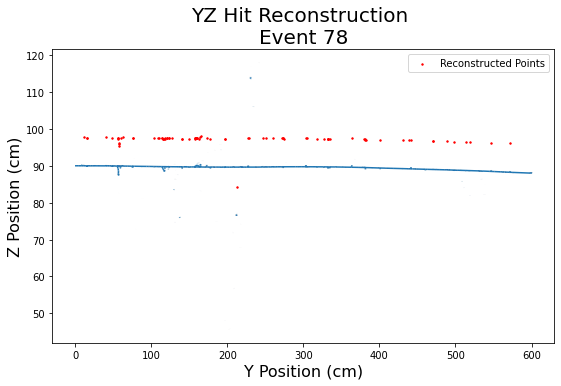

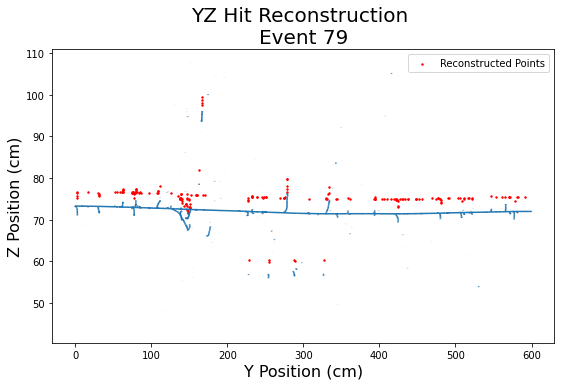

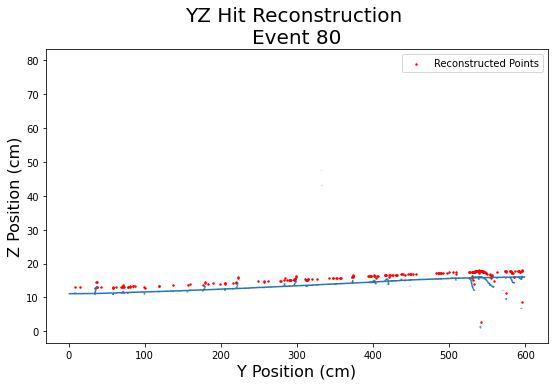

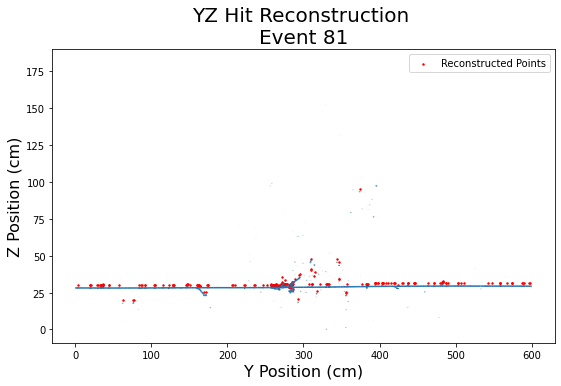

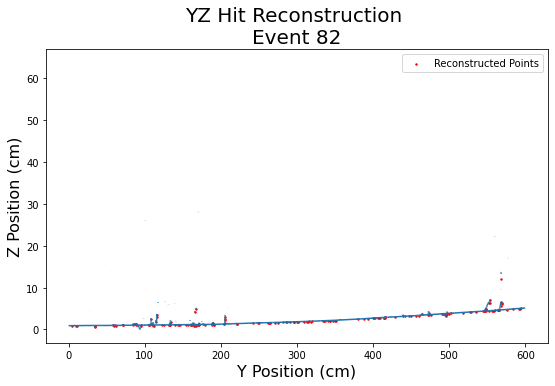

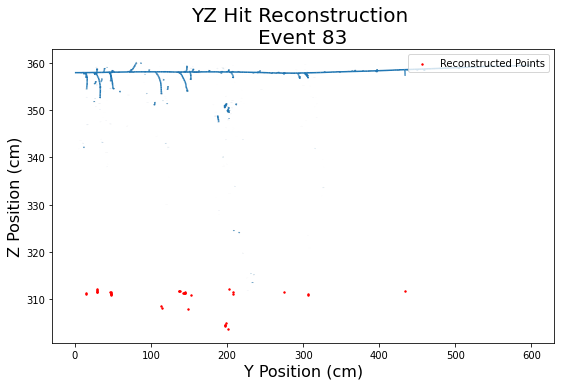

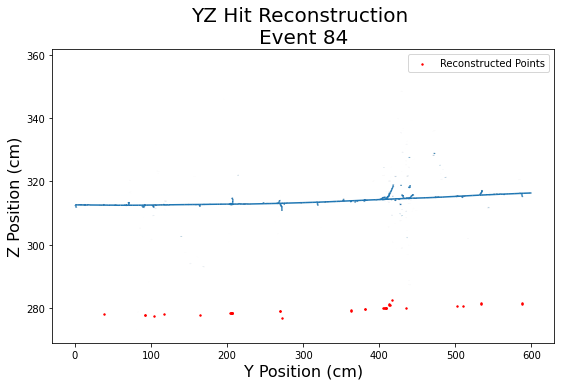

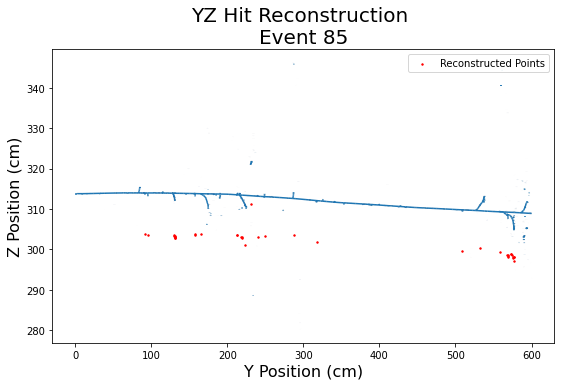

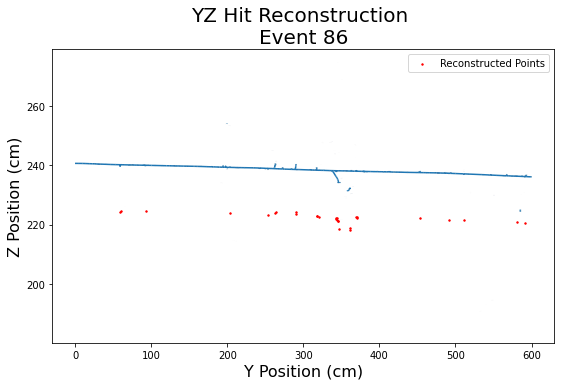

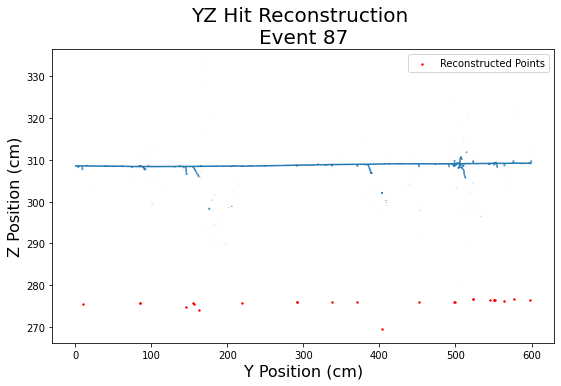

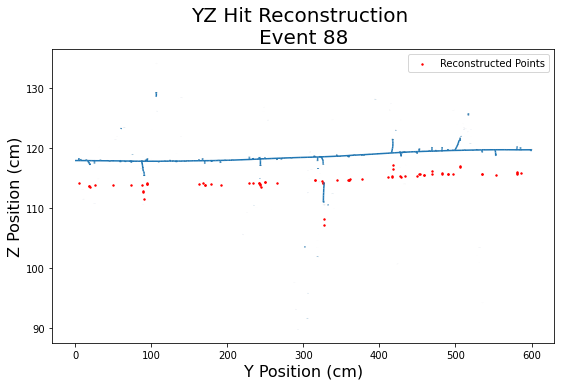

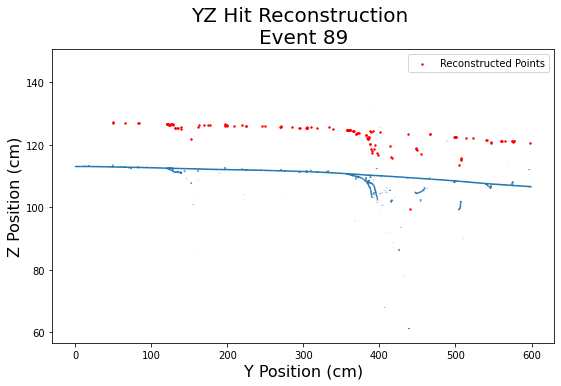

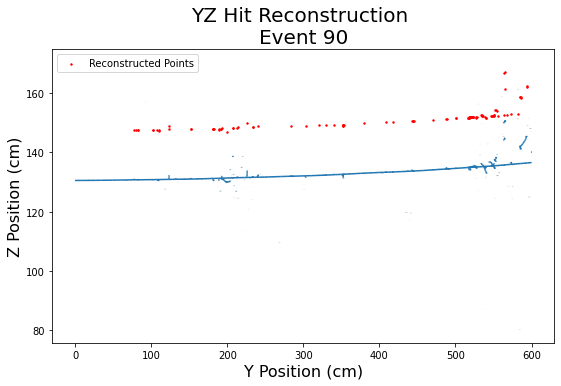

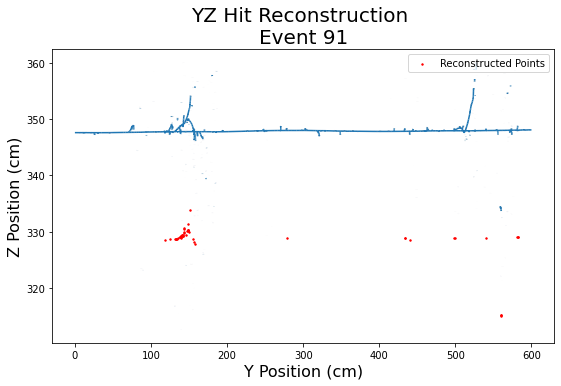

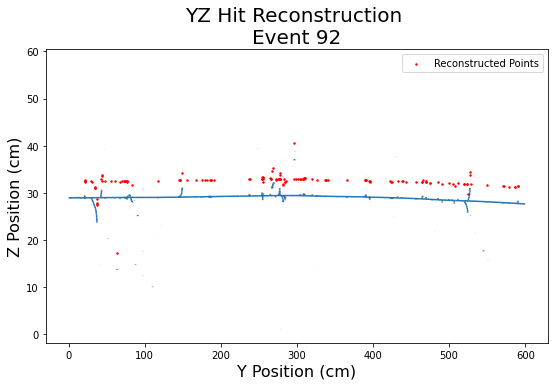

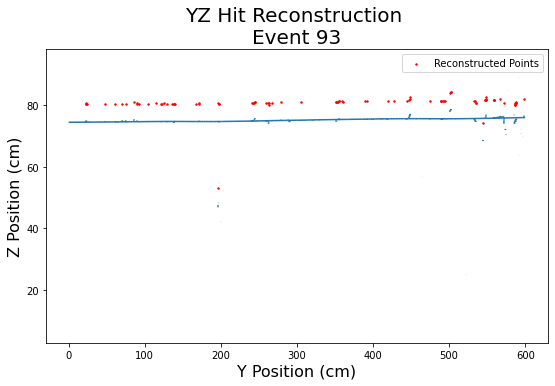

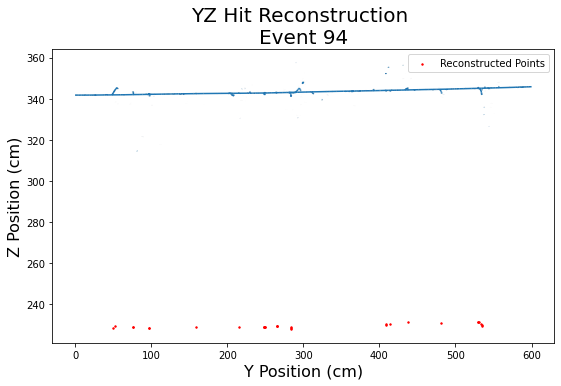

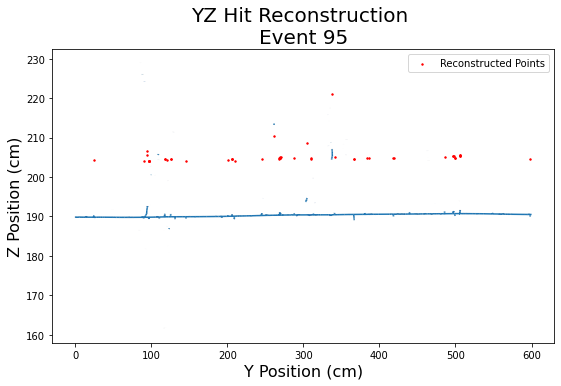

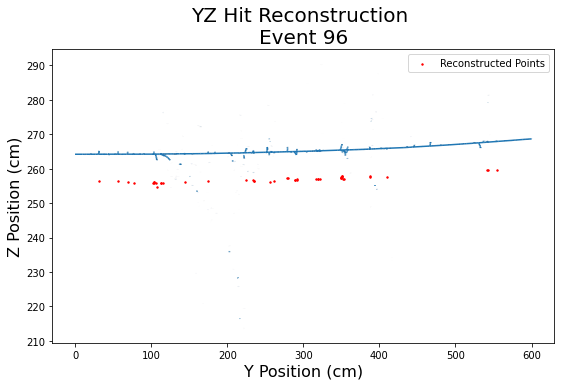

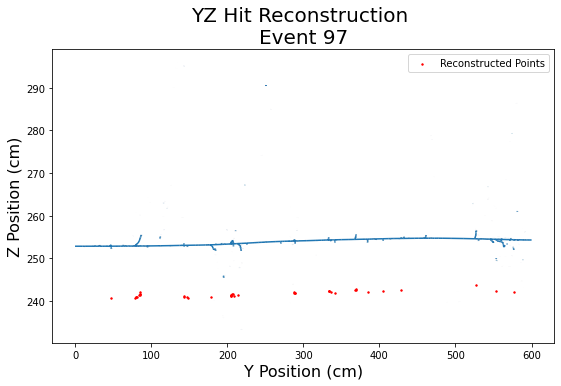

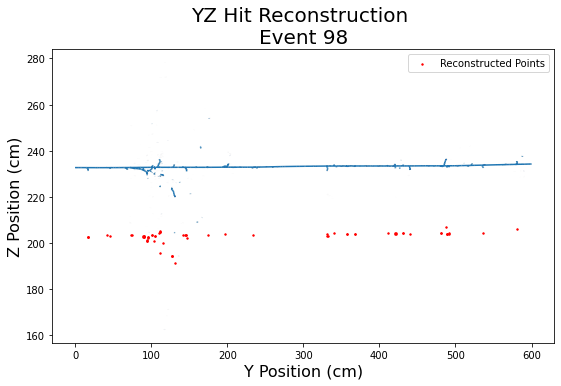

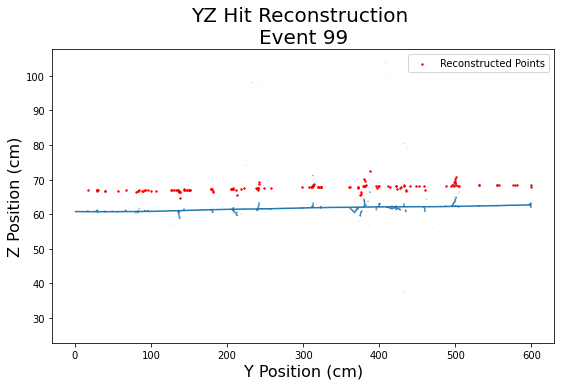

In [16]:
# Plot the YZ data for event = EVENT_NUM

for n in range(total_events):
    # Changes datafram ecolumns to arrays
    yi = pd.DataFrame(data = {"yi" : g4_df[g4_df["event"] == n]["yi"]}).to_numpy()
    zi = pd.DataFrame(data = {"zi" : g4_df[g4_df["event"] == n]["zi"]}).to_numpy()
    yf = pd.DataFrame(data = {"yf" : g4_df[g4_df["event"] == n]["yf"]}).to_numpy()
    zf = pd.DataFrame(data = {"zf" : g4_df[g4_df["event"] == n]["zf"]}).to_numpy()

    # Combines the 1D arrays to one 2D array
    initials = np.column_stack((yi, zi))
    finals = np.column_stack((yf, zf))

    # Combine to two arrays to one array with row = [[yi, zi], [yf, zf]]
    combined = np.zeros((len(initials), 2, 2))
    combined[:, 0] = initials
    combined[:, 1] = finals

    # Plot all the G4 data overlayed with the reconstruction data for all events:
    # Create the plot
    fig, ax = plt.subplots()
    fig.set_figheight(5.4)
    fig.set_figwidth(9)

    # Label the axes for the plot
    ax.set_title('YZ Hit Reconstruction \nEvent %d' %n, fontsize=20)
    ax.set_xlabel('Y Position (cm)', fontsize=16)
    ax.set_ylabel('Z Position (cm)', fontsize=16)
    
    
    # Plot the G4 data via Line Collections
    line_segments = LineCollection(combined)
    ax.add_collection(line_segments)
    ax.autoscale()
    
    
    # Plot the points from the t0 values
    # Divide by 10 to convert from mm to cm (G4 is in cm)
    ax.scatter(reconstruction_df.Y_Position[(reconstruction_df.event == n)]/10, 
                reconstruction_df.Z_Position[(reconstruction_df.event == n)]/10, s = 2, color = 'red', 
                label = 'Reconstructed Points')

    plt.legend()
    plt.show()
    plt.close()